In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"


class RBF_Add(nn.Module):
    def __init__(self, add_rbf_number, device):
        super(RBF_Add, self).__init__()

        self.add_rbf_number = add_rbf_number
        self.radial_layer_centers_list = []
        self.radial_sigma_list = []
        self.linear_layer_weights_list = []
        
        
        self.total_radial_layer_centers_list = []
        self.total_radial_sigma_list = []
        self.total_linear_layer_weights_list = []
        
        self.change_th = 3

    def rbf_gaussian(self, input_data):
        output = torch.exp(-1 * (torch.pow((input_data - self.radial_layer_centers), 2) / \
                                 (torch.pow(self.radial_sigma, 2))))

        return output  # size = (num_rbf, 1)

    def done_rbf_gaussian(self, input_data, number):
        output = torch.exp(-1 * (torch.pow(
            (input_data - self.done_radial_layer_centers[number - 1 - self.add_rbf_number:number - 1]), 2) / \
                                 (torch.pow(self.done_radial_sigma[number - 1 - self.add_rbf_number:number - 1], 2))))

        return output  # size = (num_rbf, 1)

    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.radial_layer_centers) / \
                  (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_centers2(self, input_data):
        output = (2 / (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data) + \
                ((-2* (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * \
                 self.rbf_gaussian_derivative_centers(input_data))

        return output  # size = (num_radial, 1)

    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.radial_layer_centers), 2) / \
                  (torch.pow(self.radial_sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma2(self, input_data):
        output = (4 * (input_data - self.radial_layer_centers) / (torch.pow(self.radial_sigma, 3))) * \
                    self.rbf_gaussian(input_data) + (-2*(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)) * \
                    self.rbf_gaussian_derivative_sigma(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def Loss(self, pred, target, pred_grad, true_grad):
        
        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2))

    def forward(self, input_data):
        rbf_output = self.rbf_gaussian(input_data)
        pred = torch.mm(self.linear_layer_weights, rbf_output)

        return rbf_output, pred

    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_radial_layer_centers), 2) / \
                                     (torch.pow(self.done_radial_sigma, 2))))
        pred = torch.mm(self.done_linear_layer_weights, rbf_output)

        return rbf_output, pred
    
    def L2_F(self, input_data):
        return -2 * (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)
    

    def first_rbf_parameter(self, input_data, target):
        
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()
        find_sigma = target.clone().detach()
        
        target_std = target.std()
        
        find_weight = target.clone().detach()
        center_index_list = []

        for i in range(self.add_rbf_number):
            index_ = torch.argmax(torch.abs(fine_index_target)).cpu().detach().tolist()
            fine_index_target[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)
                            

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))
    
        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def init_rbf_parameter(self, input_data, error):
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        target_std = error.std()
        center_index_list = []

        for i in range(self.add_rbf_number * (self.change_time + 1)):
            index_ = torch.argmax(torch.abs(find_index_error)).cpu().detach().tolist()

            find_index_error[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft =  (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))

        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1

    def best_forward(self, input_data, best_center, best_sigma, best_weight):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                     (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return rbf_output, pred    
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * radial_output

    def backward_propagation(self, input_data, radial_output, pred, target, target_grad, pred_grad):
        
        L2_1_error = -2 * (target - pred)
        L2_2_error = -2 * (target_grad - pred_grad)
        
        len_ = len(L2_2_error)

        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error
        deltaSigma1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        
        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error
        deltaSigma2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaSigma =  torch.sum(deltaSigma1, dim=1) + torch.sum(deltaSigma2, dim=1)

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error
        deltaCenter1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        
        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error
        deltaCenter2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        deltaCenter =  torch.sum(deltaCenter1, dim=1) + torch.sum(deltaCenter2, dim=1)

        # weight update
        delta_weight1 = torch.sum((radial_output * L2_1_error), dim=1)
        delta_weight1 = delta_weight1.reshape(1, self.add_rbf_number)
        
        delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, radial_output) * L2_2_error), dim = 1)
        delta_weight2 = delta_weight2.reshape(1, self.add_rbf_number)
        delta_weight = delta_weight1 + delta_weight2
        
        # BP update
        self.linear_layer_weights -= self.lr * delta_weight
        self.radial_layer_centers -= self.lr * deltaCenter.reshape(self.add_rbf_number, 1)
        self.radial_sigma -= self.lr * deltaSigma.reshape(self.add_rbf_number, 1)
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr

        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.change_time = 0
        self.round_number = 5
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.lr_change_th = lr_change_th
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_number
        loss = 100000

        while self.loss_th < loss:
            print(self.number)
            # first rbf
            if self.number == 0:
                cent, weig, sig = self.first_rbf_parameter(input_data, self.target[0])
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)
                first_grad = self.first_grad(input_data, target)
                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    self.backward_propagation(input_data, radial_output, pred, self.target, first_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, first_grad)
                    if epo == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    else:
                        if self.best_loss > epo_loss:
                            self.best_loss = epo_loss.clone().detach()
                            self.best_center = self.radial_layer_centers.clone().detach()
                            self.best_sigma = self.radial_sigma.clone().detach()
                            self.best_weight = self.linear_layer_weights.clone().detach()
                    if (epo + 1) % 250 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

            # additional rbf
            else:
                # init parameter
                self.change_init(na)
                if self.change_time > break_time:
                    break
                cent, weig, sig = self.init_rbf_parameter(input_data, self.target[0])
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)

                for epo in range(epochs):
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    
                    if epo == 0:
                        print(self.Loss(pred, self.target, rbf_grad, target_grad))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
                    self.backward_propagation(input_data, radial_output, pred, self.target, target_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epo + 1) % 1000 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

                    # best parameter
                    if self.best_loss > epo_loss:
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
            radial_output, best_pred = self.best_forward(input_data, self.best_center, self.best_sigma,
                                                         self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print('train_loss', train_loss)
            print("best loss : ", self.best_loss)

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')

            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')

            self.train_loss_list.append(torch.round(train_loss * (10 ** self.round_number)) / 10 ** self.round_number)

            # additional rbf plot print
            plt.figure(figsize=(10, 5))
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.radial_layer_centers_list.append(self.best_center)
                self.radial_sigma_list.append(self.best_sigma)
                self.linear_layer_weights_list.append(self.best_weight)

                self.done_radial_layer_centers = torch.cat(self.radial_layer_centers_list, 0)
                self.done_radial_sigma = torch.cat(self.radial_sigma_list, 0)
                self.done_linear_layer_weights = torch.cat(self.linear_layer_weights_list, 1)
                target_grad = self.target_grad(input_data, self.done_radial_layer_centers, self.done_radial_sigma, self.done_linear_layer_weights, first_grad)
            else:
                na = 0

In [19]:
import numpy as np
a = np.arange(0,10,0.05)
    
y = 2*a**3 - 16*a**2 + 2*a -10
y2 = 3*a**2 -16*a - 30
y3 = 5*a**2 +25*a - a**3


target1 = torch.tensor(y, device = device).reshape((1,200))
target2 = torch.tensor(y2, device = device).reshape((1,200))
target = torch.tensor(y3, device = device).reshape((1,200))
input_ = torch.tensor(a, device = device)

In [11]:
a = np.arange(0,10,0.05)
    
y = 5*a*np.sin(np.pi*a/4)

target3 = torch.tensor(y, device = device).reshape((1,200))
input_2 = torch.tensor(a, device = device)

0
0 epoch MSE Loss: 125160.5793099156
249 epoch MSE Loss: 35.34569227578768
499 epoch MSE Loss: 55.559471790608754
749 epoch MSE Loss: 32.553996981203376
999 epoch MSE Loss: 29.681642160289826
1249 epoch MSE Loss: 27.304714168050396
1499 epoch MSE Loss: 25.02985564010779
1749 epoch MSE Loss: 22.735801429238673
1999 epoch MSE Loss: 20.39279427885489
2249 epoch MSE Loss: 18.056774273440137
2499 epoch MSE Loss: 15.873283980018401
2749 epoch MSE Loss: 14.062692465914491
2999 epoch MSE Loss: 12.750555406570452
3249 epoch MSE Loss: 11.780582684477604
3499 epoch MSE Loss: 11.00032645797846
3749 epoch MSE Loss: 10.332168993286702
3999 epoch MSE Loss: 9.732369549731605
4249 epoch MSE Loss: 9.181629700388402
4499 epoch MSE Loss: 8.676181305036623
4749 epoch MSE Loss: 8.216301124774706
4999 epoch MSE Loss: 7.799603665836542
train_loss tensor(7.7980, device='cuda:0', dtype=torch.float64)
best loss :  tensor(7.7996, device='cuda:0', dtype=torch.float64)
change lr  0.0001
---------------------------

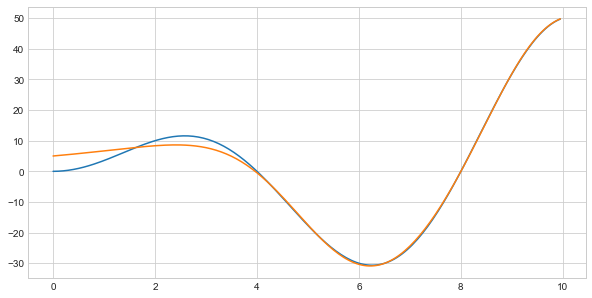

1
tensor(1289.2809, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 2.8413336589922156
1999 epoch MSE Loss: 0.7003528830638827
2999 epoch MSE Loss: 0.6395592254880805
3999 epoch MSE Loss: 0.6034481858381937
4999 epoch MSE Loss: 0.5680385093109636
train_loss tensor(0.5680, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.5680, device='cuda:0', dtype=torch.float64)
change round number 6
----------------------------------------------


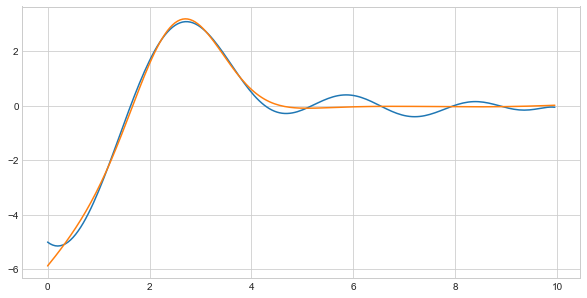

2
tensor(7.2419, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.25812481241567325
1999 epoch MSE Loss: 0.2514452192823663
2999 epoch MSE Loss: 0.24610301535036164
3999 epoch MSE Loss: 0.24132424670712657
4999 epoch MSE Loss: 0.23720903986158157
train_loss tensor(0.2372, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.2372, device='cuda:0', dtype=torch.float64)
change lr  0.001
----------------------------------------------


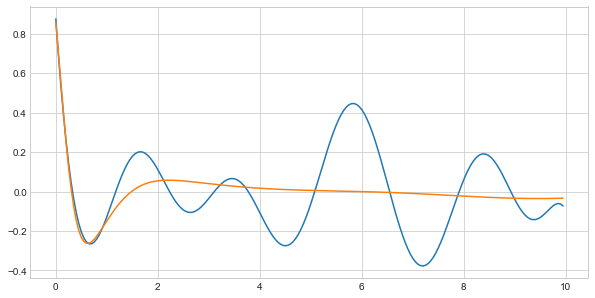

3
tensor(11.3657, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.04011531795550454
1999 epoch MSE Loss: 0.032723676921787875
2999 epoch MSE Loss: 0.03320230046000771
3999 epoch MSE Loss: 0.03464948023959999
4999 epoch MSE Loss: 0.03452265913540825
train_loss tensor(0.0312, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0312, device='cuda:0', dtype=torch.float64)


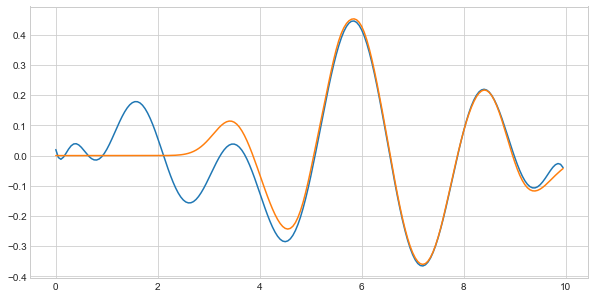

4
tensor(1.8365, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.007159569713074785
1999 epoch MSE Loss: 0.0149560118846322
2999 epoch MSE Loss: 0.0070552975272621336
3999 epoch MSE Loss: 0.006341110245862809
4999 epoch MSE Loss: 0.005517211524841205
train_loss tensor(0.0055, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0055, device='cuda:0', dtype=torch.float64)
change lr  0.01
----------------------------------------------


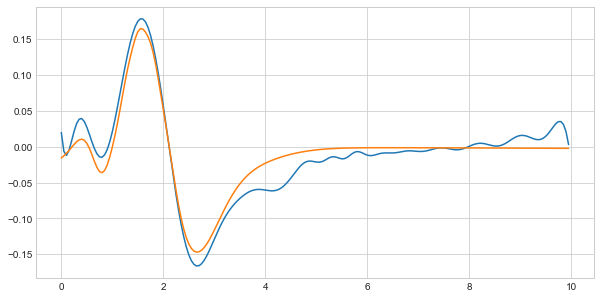

53.14761 sec


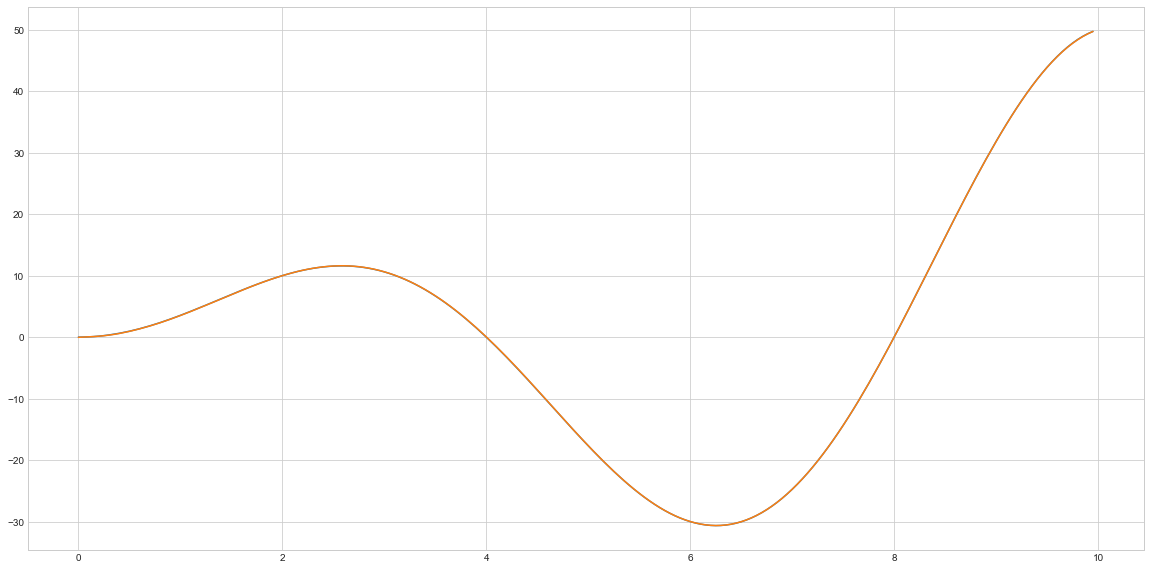

In [13]:
start = time.time()
model2 = RBF_Add(30, device)
model2.train(input_2, target3, 5000, 1e-05, 0.01, 10)
end = time.time()
print(f"{end - start:.5f} sec")

plt.figure(figsize=(20,10))
plt.plot(input_2.cpu().detach().numpy(), target3[0].cpu().detach().numpy())
plt.plot(input_2.cpu().detach().numpy(), model2.pred(input_2)[1][0].cpu().detach().numpy())
#rbf_grad2 = rbf_gradient(input_2, model2.done_radial_layer_centers, model2.done_radial_sigma, model2.done_linear_layer_weights)

0
0 epoch MSE Loss: 5782690.681872418
249 epoch MSE Loss: 21066.34437593793
499 epoch MSE Loss: 20692.325004995728
749 epoch MSE Loss: 20471.44014720692
999 epoch MSE Loss: 20328.77162266207
1249 epoch MSE Loss: 20227.275130045164
1499 epoch MSE Loss: 20147.289913186523
1749 epoch MSE Loss: 20077.242491498317
1999 epoch MSE Loss: 20009.150131110688
2249 epoch MSE Loss: 19935.84820654236
2499 epoch MSE Loss: 19847.925342407412
2749 epoch MSE Loss: 19725.996187346733
2999 epoch MSE Loss: 19495.326597205374
3249 epoch MSE Loss: 11278.800001125694
3499 epoch MSE Loss: 14992.445557376053
3749 epoch MSE Loss: 17894.58913726731
3999 epoch MSE Loss: 15989.046764607052
4249 epoch MSE Loss: 23739.159190077753
4499 epoch MSE Loss: 16909.349705680874
4749 epoch MSE Loss: 11629.864019510862
4999 epoch MSE Loss: 6477.858615462727
train_loss tensor(5539.0635, device='cuda:0', dtype=torch.float64)
best loss :  tensor(5315.6554, device='cuda:0', dtype=torch.float64)


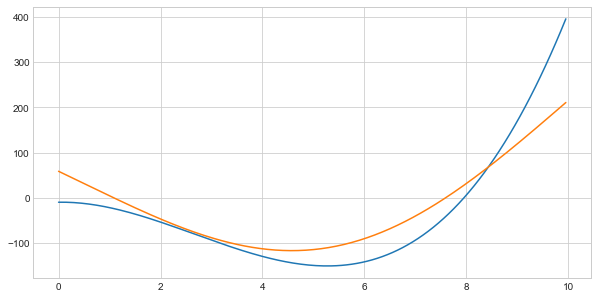

1
tensor(720904.7047, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 613.0821650466828
1999 epoch MSE Loss: 1140.8761703003008
2999 epoch MSE Loss: 879.2069542357477
3999 epoch MSE Loss: 905.0445841849423
4999 epoch MSE Loss: 920.9667225184174
train_loss tensor(384.6941, device='cuda:0', dtype=torch.float64)
best loss :  tensor(362.0980, device='cuda:0', dtype=torch.float64)


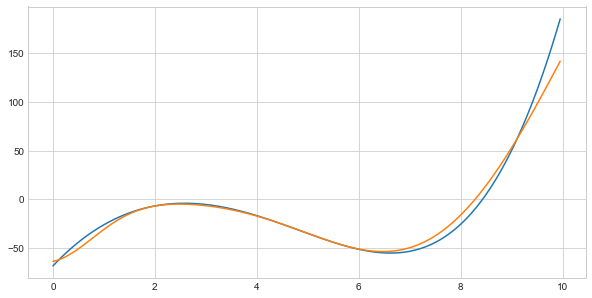

2
tensor(7044.2154, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 49.380538448355985
1999 epoch MSE Loss: 48.379404451866485
2999 epoch MSE Loss: 48.301141141154865
3999 epoch MSE Loss: 46.53862154044544
4999 epoch MSE Loss: 45.40267251558182
train_loss tensor(45.4021, device='cuda:0', dtype=torch.float64)
best loss :  tensor(45.4027, device='cuda:0', dtype=torch.float64)


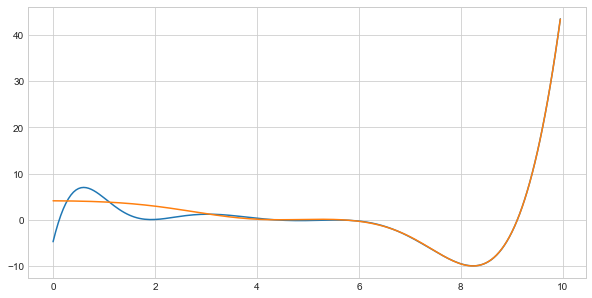

3
tensor(601.3766, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 34.58007910184898
1999 epoch MSE Loss: 36.843044194277184
2999 epoch MSE Loss: 38.27286784636038
3999 epoch MSE Loss: 38.671295216093554
4999 epoch MSE Loss: 40.13804411749326
train_loss tensor(2.9173, device='cuda:0', dtype=torch.float64)
best loss :  tensor(2.9170, device='cuda:0', dtype=torch.float64)
change lr  0.0001
----------------------------------------------
change round number 6
----------------------------------------------


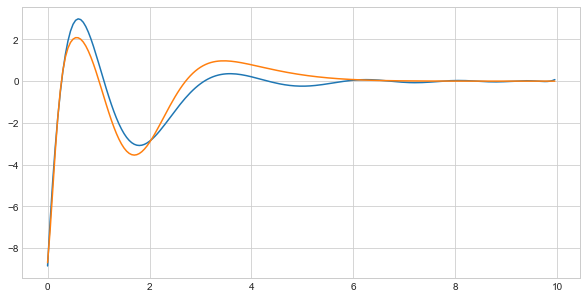

4
tensor(12.6810, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 2.36843595991463
1999 epoch MSE Loss: 2.275880998619668
2999 epoch MSE Loss: 2.2390141960151553
3999 epoch MSE Loss: 2.217711613450331
4999 epoch MSE Loss: 2.2027202069930945
train_loss tensor(2.2027, device='cuda:0', dtype=torch.float64)
best loss :  tensor(2.2027, device='cuda:0', dtype=torch.float64)


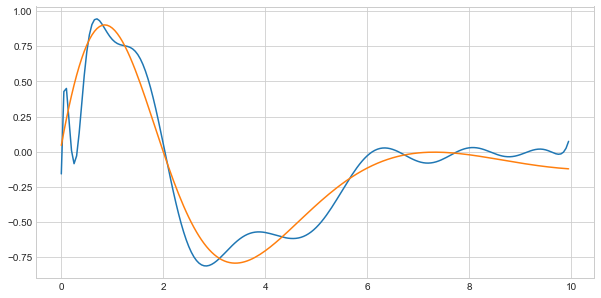

5
tensor(3.0044, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 2.1913138141082587
1999 epoch MSE Loss: 2.1787183610032828
2999 epoch MSE Loss: 2.1659578638744046
3999 epoch MSE Loss: 2.1523677619103685
4999 epoch MSE Loss: 2.1417814151713634
train_loss tensor(2.1418, device='cuda:0', dtype=torch.float64)
best loss :  tensor(2.1418, device='cuda:0', dtype=torch.float64)


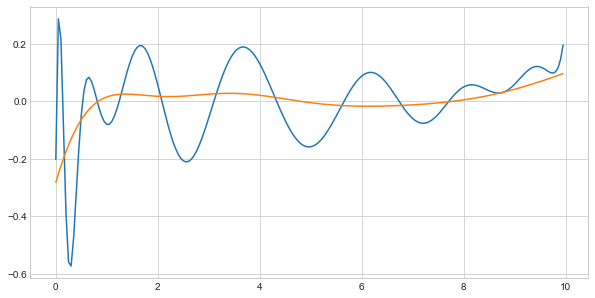

6
tensor(2.8150, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 2.128027264774497
1999 epoch MSE Loss: 2.1046143008521403
2999 epoch MSE Loss: 2.086321476636668
3999 epoch MSE Loss: 2.0696215428674187
4999 epoch MSE Loss: 1.7399369377518141
train_loss tensor(1.0948, device='cuda:0', dtype=torch.float64)
best loss :  tensor(1.0751, device='cuda:0', dtype=torch.float64)


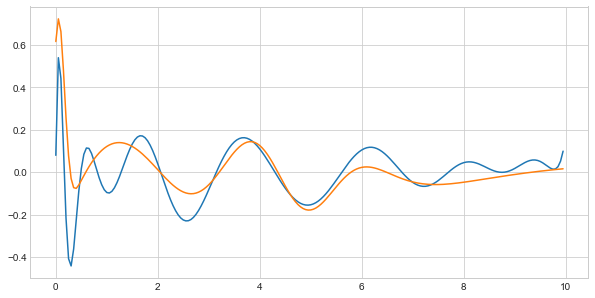

7
tensor(9.3606, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.9140905978767954
1999 epoch MSE Loss: 0.9238350551003822
2999 epoch MSE Loss: 0.961511662107874
3999 epoch MSE Loss: 0.9298760415953247
4999 epoch MSE Loss: 0.9291807489692693
train_loss tensor(0.9055, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.9055, device='cuda:0', dtype=torch.float64)


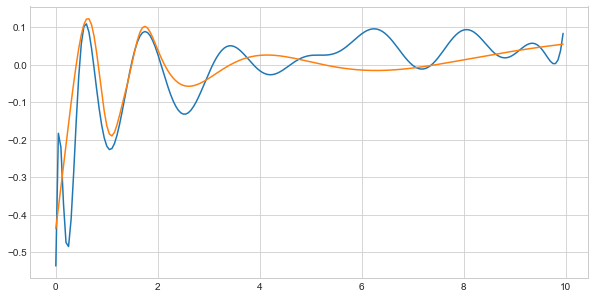

8
tensor(1.7480, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.8978629744629555
1999 epoch MSE Loss: 0.8965634856635647
2999 epoch MSE Loss: 0.8976581852410744
3999 epoch MSE Loss: 0.9003247485893867
4999 epoch MSE Loss: 0.89850721157511
train_loss tensor(0.8965, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.8965, device='cuda:0', dtype=torch.float64)


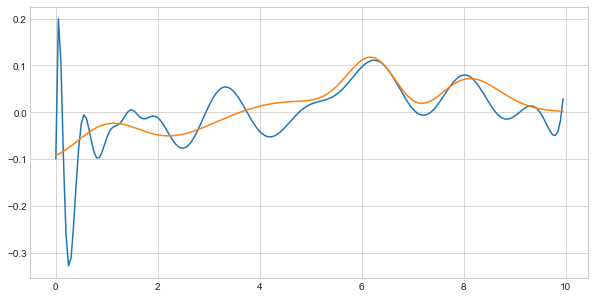

9
tensor(1.1899, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.8925728094750178
1999 epoch MSE Loss: 0.8818428358487894
2999 epoch MSE Loss: 0.8876257296982955
3999 epoch MSE Loss: 0.891353365089891
4999 epoch MSE Loss: 0.8926555713310168
train_loss tensor(1.5047, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.4180, device='cuda:0', dtype=torch.float64)


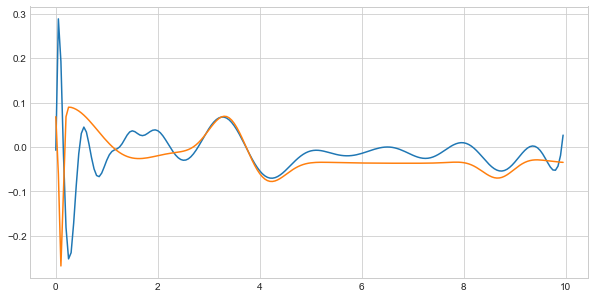

10
tensor(1.7455, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 1.0763128313638122
1999 epoch MSE Loss: 1.0568180416862634
2999 epoch MSE Loss: 1.0262101103789636
3999 epoch MSE Loss: 1.0135125138526377
4999 epoch MSE Loss: 0.9527606042028637
train_loss tensor(0.7124, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.7124, device='cuda:0', dtype=torch.float64)


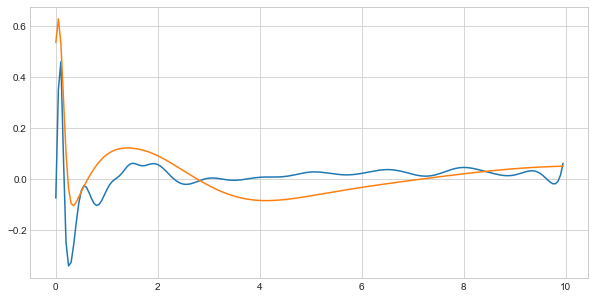

11
tensor(3.3056, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.5746179388704834
1999 epoch MSE Loss: 0.5839428037843188
2999 epoch MSE Loss: 0.5873620650001578
3999 epoch MSE Loss: 0.6012802002352949
4999 epoch MSE Loss: 0.5906310734499447
train_loss tensor(0.5740, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.5740, device='cuda:0', dtype=torch.float64)


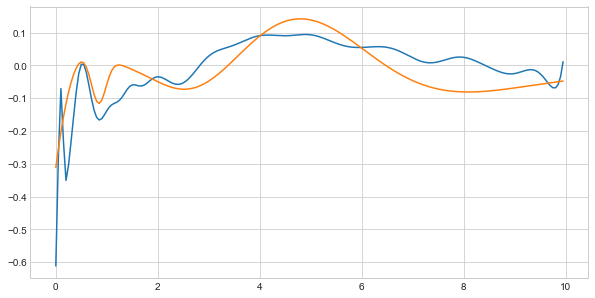

12
tensor(1.8411, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.360205400302366
1999 epoch MSE Loss: 0.44524480101423247
2999 epoch MSE Loss: 0.4868863894778124
3999 epoch MSE Loss: 0.4599616637901396
4999 epoch MSE Loss: 0.4871397463028271
train_loss tensor(0.3475, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.3474, device='cuda:0', dtype=torch.float64)


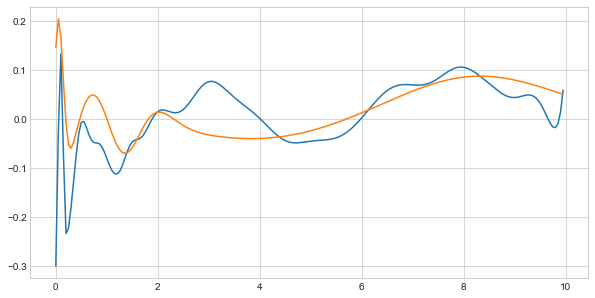

13
tensor(1.1012, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.2786198644666548
1999 epoch MSE Loss: 0.30587239757908713
2999 epoch MSE Loss: 0.22444800003114335
3999 epoch MSE Loss: 0.20937587299895932
4999 epoch MSE Loss: 0.13965045538904927
train_loss tensor(0.0444, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0433, device='cuda:0', dtype=torch.float64)
change lr  0.001
----------------------------------------------


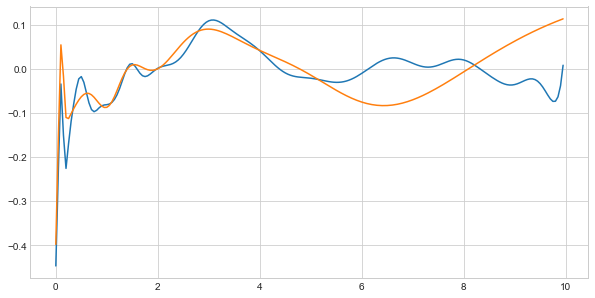

14
tensor(1.4073, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.03707122003027606
1999 epoch MSE Loss: 0.036749503998803286
2999 epoch MSE Loss: 0.03639257336874525
3999 epoch MSE Loss: 0.035502511999575735
4999 epoch MSE Loss: 0.029876851473825794
train_loss tensor(0.0297, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0297, device='cuda:0', dtype=torch.float64)


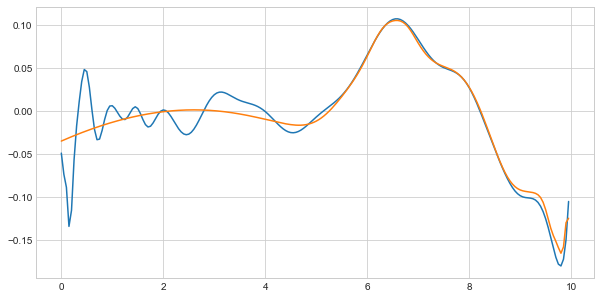

15
tensor(0.0410, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.004499533637424718
1999 epoch MSE Loss: 0.00719662149913387
2999 epoch MSE Loss: 0.004856076521015617
3999 epoch MSE Loss: 0.004833470255084036
4999 epoch MSE Loss: 0.004772055405237526
train_loss tensor(0.0038, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0037, device='cuda:0', dtype=torch.float64)
change lr  0.01
----------------------------------------------


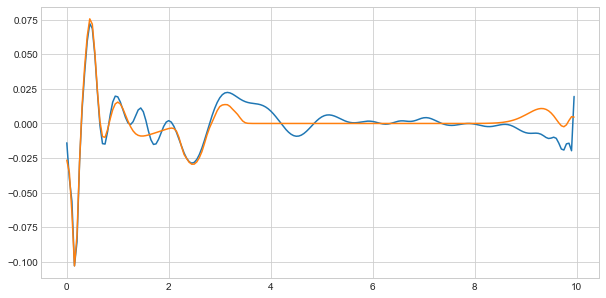

165.20006 sec


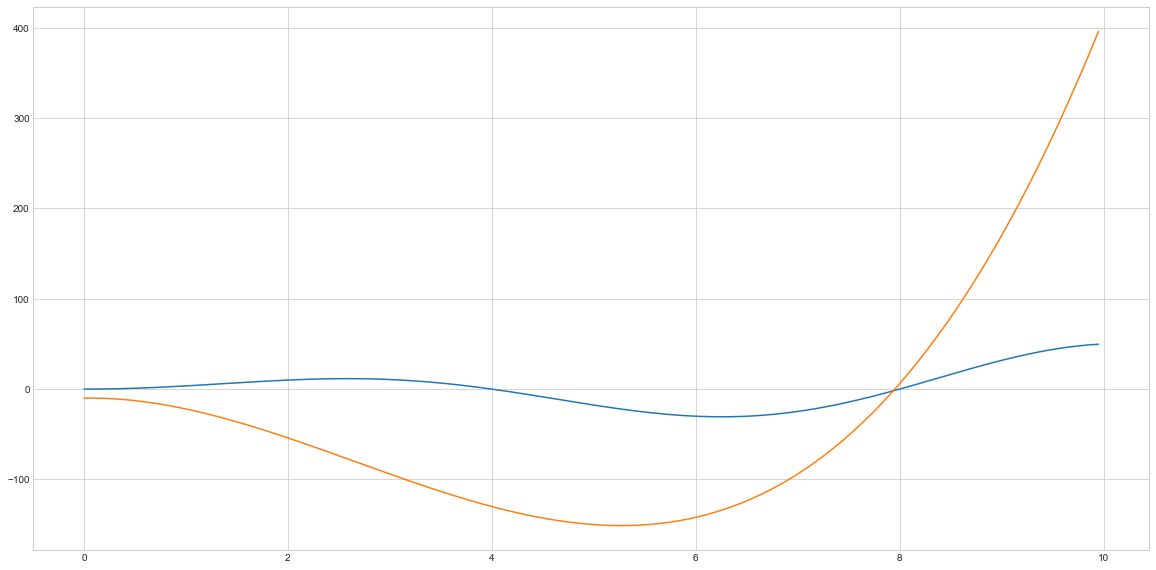

In [16]:
start = time.time()
model2 = RBF_Add(30, device)
model2.train(input_, target1, 5000, 1e-05, 0.01, 10)
end = time.time()
print(f"{end - start:.5f} sec")

plt.figure(figsize=(20,10))
plt.plot(input_.cpu().detach().numpy(), target1[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model2.pred(input_)[1][0].cpu().detach().numpy())
#rbf_grad2 = rbf_gradient(input_2, model2.done_radial_layer_centers, model2.done_radial_sigma, model2.done_linear_layer_weights)

0
0 epoch MSE Loss: 1876216.2623612457
249 epoch MSE Loss: 9342.450988304969
499 epoch MSE Loss: 9331.973551560155
749 epoch MSE Loss: 9322.547486856893
999 epoch MSE Loss: 9314.065654091683
1249 epoch MSE Loss: 9306.353994225474
1499 epoch MSE Loss: 9299.239258784273
1749 epoch MSE Loss: 9292.5725062063
1999 epoch MSE Loss: 9286.232143632804
2249 epoch MSE Loss: 9280.120266001719
2499 epoch MSE Loss: 9274.157875871477
2749 epoch MSE Loss: 9268.280684750569
2999 epoch MSE Loss: 9262.435777647996
3249 epoch MSE Loss: 9256.579021793743
3499 epoch MSE Loss: 9250.673041736865
3749 epoch MSE Loss: 9244.68561319797
3999 epoch MSE Loss: 9238.58836787816
4249 epoch MSE Loss: 9232.355732150336
4499 epoch MSE Loss: 9225.96404320323
4749 epoch MSE Loss: 9219.390799520936
4999 epoch MSE Loss: 9212.61401114754
train_loss tensor(9212.5865, device='cuda:0', dtype=torch.float64)
best loss :  tensor(9212.6140, device='cuda:0', dtype=torch.float64)


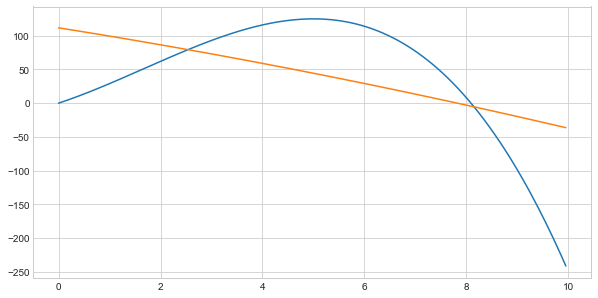

1
tensor(1382445.9412, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 9086.436601004356
1999 epoch MSE Loss: 8470.685374055905
2999 epoch MSE Loss: 7928.152760948492
3999 epoch MSE Loss: 7787.179411126138
4999 epoch MSE Loss: 5869.686682734689
train_loss tensor(9325.9985, device='cuda:0', dtype=torch.float64)
best loss :  tensor(5374.9137, device='cuda:0', dtype=torch.float64)


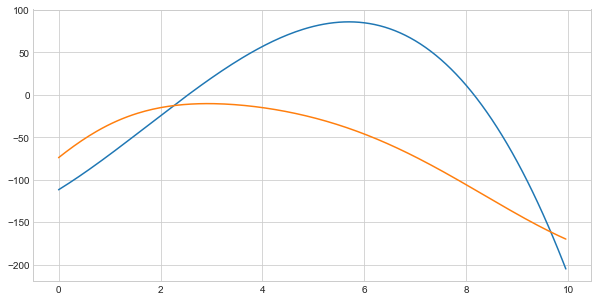

2
tensor(10022763.7383, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 5722.096229788517
1999 epoch MSE Loss: 5669.997547181903
2999 epoch MSE Loss: 5571.859186561247
3999 epoch MSE Loss: 5380.556524801582
4999 epoch MSE Loss: 5194.440356510444
train_loss tensor(5194.2818, device='cuda:0', dtype=torch.float64)
best loss :  tensor(5194.4404, device='cuda:0', dtype=torch.float64)


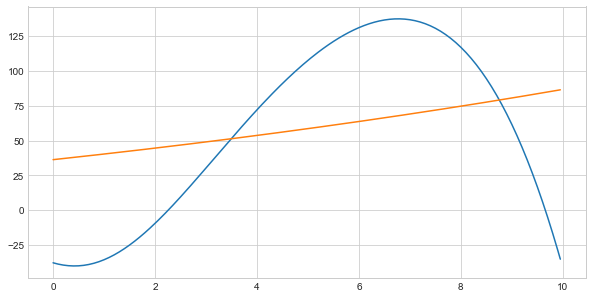

3
tensor(729955.0894, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 2800.830095086284
1999 epoch MSE Loss: 2379.391148454563
2999 epoch MSE Loss: 3012.4093729824112
3999 epoch MSE Loss: 3151.5223819896173
4999 epoch MSE Loss: 3146.873527659383
train_loss tensor(5029.3769, device='cuda:0', dtype=torch.float64)
best loss :  tensor(1053.4137, device='cuda:0', dtype=torch.float64)


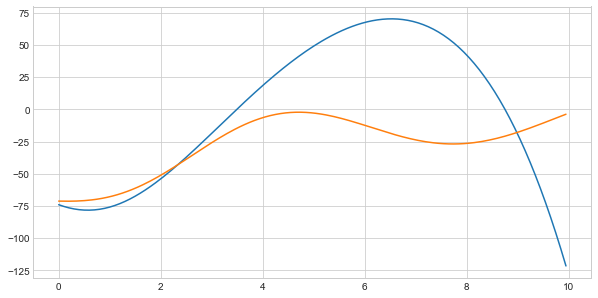

4
tensor(1408474.5824, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 4556.730105184942
1999 epoch MSE Loss: 4504.068021258176
2999 epoch MSE Loss: 4408.668474540466
3999 epoch MSE Loss: 4271.700323312659
4999 epoch MSE Loss: 3912.8646095283134
train_loss tensor(3912.6641, device='cuda:0', dtype=torch.float64)
best loss :  tensor(3912.8646, device='cuda:0', dtype=torch.float64)


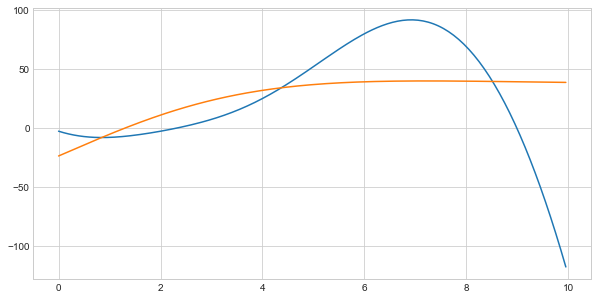

5
tensor(432933.1789, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 952.8190450782454
1999 epoch MSE Loss: 846.5100148167412
2999 epoch MSE Loss: 865.7159740121596
3999 epoch MSE Loss: 1442.6904851641498
4999 epoch MSE Loss: 996.3151936914093
train_loss tensor(299.5743, device='cuda:0', dtype=torch.float64)
best loss :  tensor(125.0139, device='cuda:0', dtype=torch.float64)


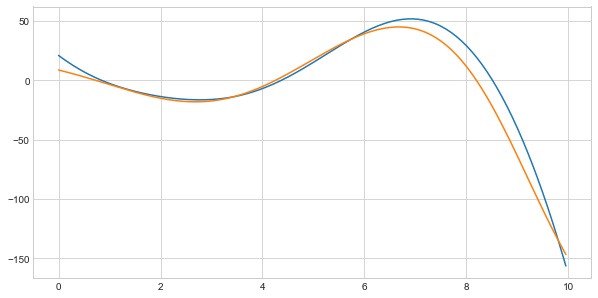

6
tensor(141517.3998, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 253.54143891390655
1999 epoch MSE Loss: 250.72370065074145
2999 epoch MSE Loss: 246.02678613148237
3999 epoch MSE Loss: 177.41873709169934
4999 epoch MSE Loss: 169.03035459169746
train_loss tensor(169.0264, device='cuda:0', dtype=torch.float64)
best loss :  tensor(169.0304, device='cuda:0', dtype=torch.float64)


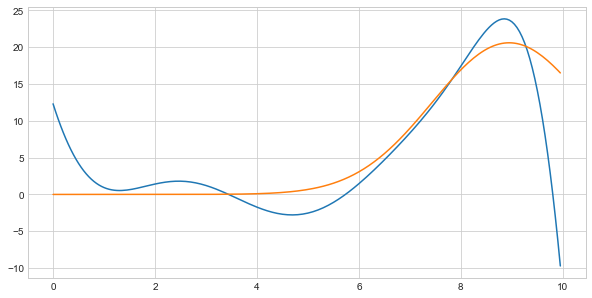

7
tensor(3329.6845, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 2.946471427536039
1999 epoch MSE Loss: 2.663847356134441
2999 epoch MSE Loss: 2.4551935603626482
3999 epoch MSE Loss: 2.2417996548563814
4999 epoch MSE Loss: 2.043399283209709
train_loss tensor(2.0432, device='cuda:0', dtype=torch.float64)
best loss :  tensor(2.0434, device='cuda:0', dtype=torch.float64)
change lr  0.0001
----------------------------------------------
change round number 6
----------------------------------------------


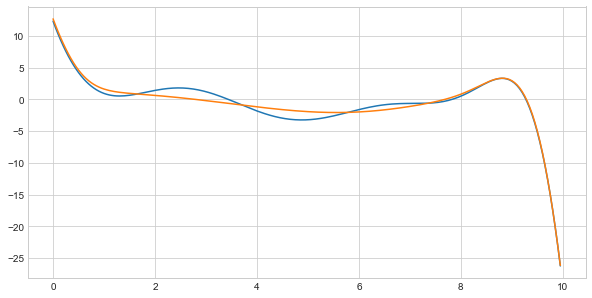

8
tensor(154.8595, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.250576924573153
1999 epoch MSE Loss: 0.24424968371017947
2999 epoch MSE Loss: 0.24095444764621768
3999 epoch MSE Loss: 0.23897413564425615
4999 epoch MSE Loss: 0.2376271523212466
train_loss tensor(0.2376, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.2376, device='cuda:0', dtype=torch.float64)
change lr  0.001
----------------------------------------------


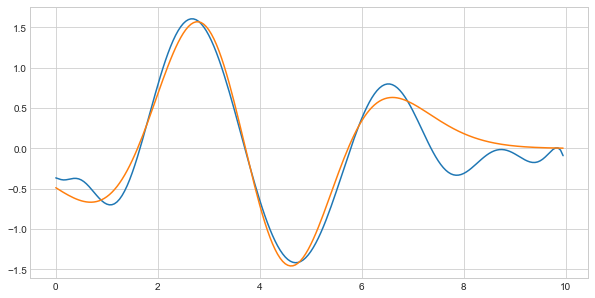

9
tensor(21.5174, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.10149712158885005
1999 epoch MSE Loss: 0.035387074058686796
2999 epoch MSE Loss: 0.03895610478177841
3999 epoch MSE Loss: 0.031462630746105044
4999 epoch MSE Loss: 0.026666366668549248
train_loss tensor(0.0259, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0258, device='cuda:0', dtype=torch.float64)


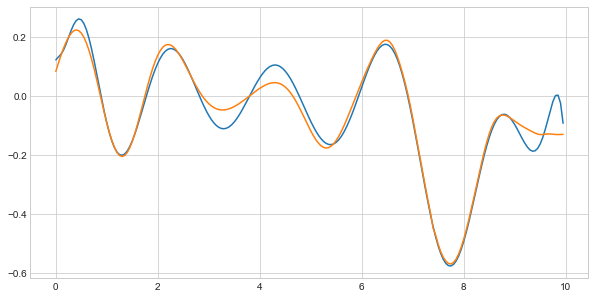

10
tensor(0.1500, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.0047384701614352365
1999 epoch MSE Loss: 0.0046063432742660315
2999 epoch MSE Loss: 0.004773241324096454
3999 epoch MSE Loss: 0.005019809670689446
4999 epoch MSE Loss: 0.004768835037700692
train_loss tensor(0.0046, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0046, device='cuda:0', dtype=torch.float64)
change lr  0.01
----------------------------------------------


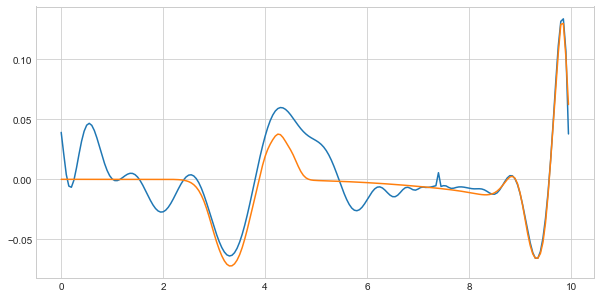

115.08700 sec


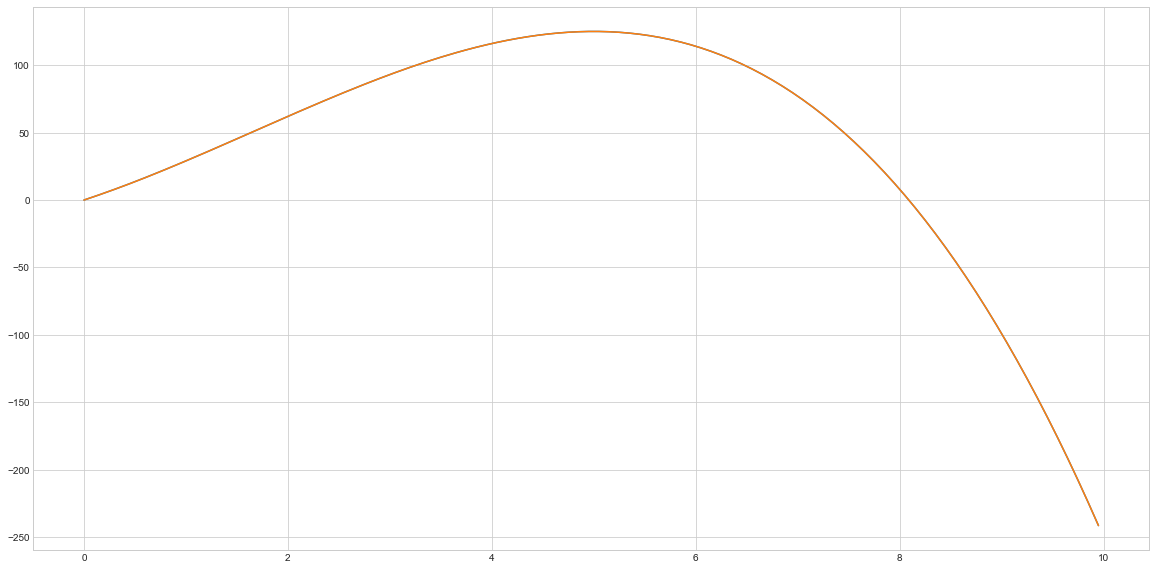

In [17]:
start = time.time()
model3 = RBF_Add(30, device)
model3.train(input_, target, 5000, 1e-05, 0.01, 10)
end = time.time()
print(f"{end - start:.5f} sec")

plt.figure(figsize=(20,10))
plt.plot(input_.cpu().detach().numpy(), target[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model3.pred(input_)[1][0].cpu().detach().numpy())
#rbf_grad2 = rbf_gradient(input_2, model3.done_radial_layer_centers, model3.done_radial_sigma, model3.done_linear_layer_weights)

0
0 epoch MSE Loss: 960871.7137219858
249 epoch MSE Loss: 748.6673838700724
499 epoch MSE Loss: 422.38531096793906
749 epoch MSE Loss: 204.03010640327966
999 epoch MSE Loss: 38.56112506327151
1249 epoch MSE Loss: 22.64893412932279
1499 epoch MSE Loss: 15.487667341168736
1749 epoch MSE Loss: 11.440209399523619
1999 epoch MSE Loss: 9.055390116326022
2249 epoch MSE Loss: 7.646593734851424
2499 epoch MSE Loss: 6.84178556378693
2749 epoch MSE Loss: 6.418999944647246
2999 epoch MSE Loss: 6.235712370314738
3249 epoch MSE Loss: 6.196746262450631
3499 epoch MSE Loss: 6.238770282430781
3749 epoch MSE Loss: 6.321428783451712
3999 epoch MSE Loss: 6.420860534161946
4249 epoch MSE Loss: 6.5243547700772275
4499 epoch MSE Loss: 6.626099596759994
4749 epoch MSE Loss: 6.724125343300263
4999 epoch MSE Loss: 6.8183409756285345
train_loss tensor(6.1961, device='cuda:0', dtype=torch.float64)
best loss :  tensor(6.1961, device='cuda:0', dtype=torch.float64)
change lr  0.0001
---------------------------------

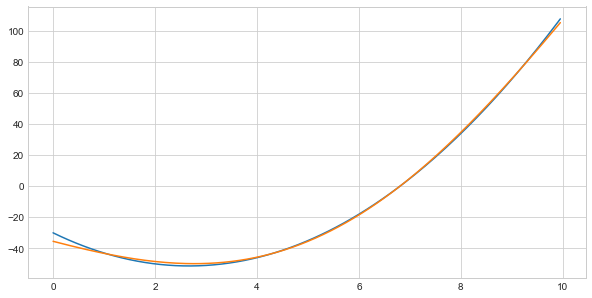

1
tensor(173.2973, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.5226439665967746
1999 epoch MSE Loss: 0.12362246568141917
2999 epoch MSE Loss: 0.0401350053834079
3999 epoch MSE Loss: 0.017778713863640477
4999 epoch MSE Loss: 0.00960968983162278
train_loss tensor(0.0096, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0096, device='cuda:0', dtype=torch.float64)
change lr  0.001
----------------------------------------------
change round number 6
----------------------------------------------


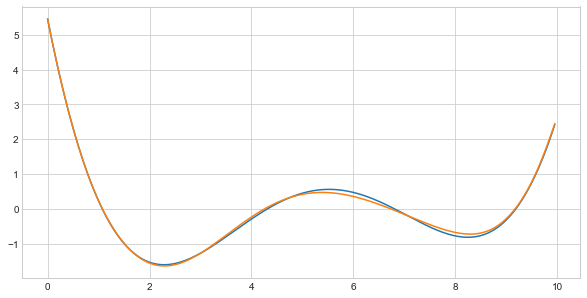

21.14903 sec


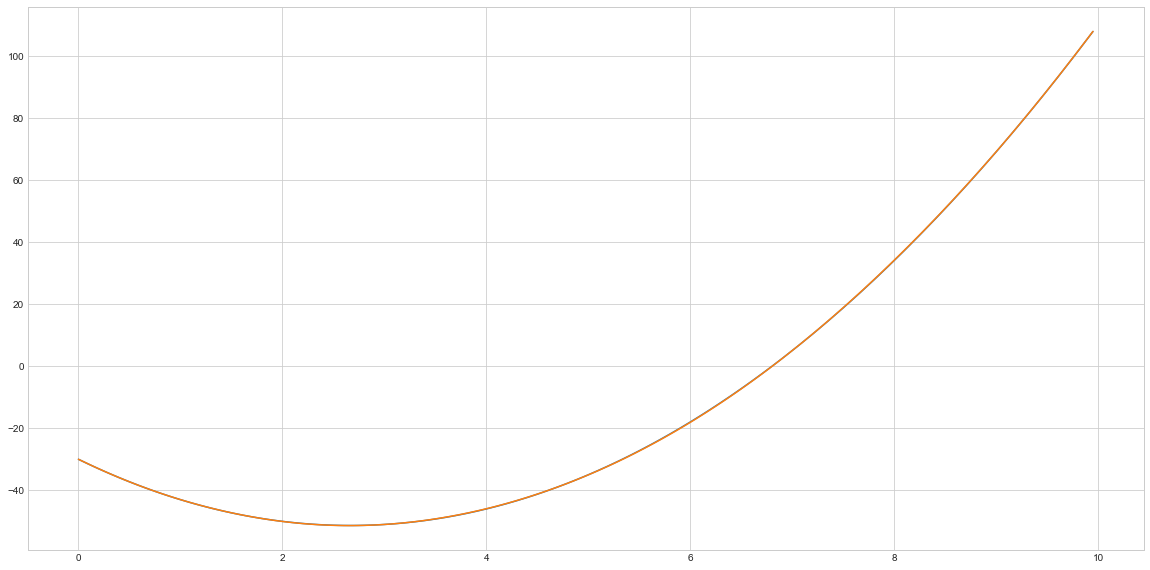

In [20]:
start = time.time()
model4 = RBF_Add(30, device)
model4.train(input_, target2, 5000, 1e-05, 0.01, 10)
end = time.time()
print(f"{end - start:.5f} sec")

plt.figure(figsize=(20,10))
plt.plot(input_.cpu().detach().numpy(), target2[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model4.pred(input_)[1][0].cpu().detach().numpy())
#rbf_grad2 = rbf_gradient(input_2, model4.done_radial_layer_centers, model4.done_radial_sigma, model4.done_linear_layer_weights)

In [3]:
import numpy as np
a = np.arange(0,10,0.05)
    
y = 2*a**3 - 16*a**2 + 2*a -10
y2 = 3*a**2 -16*a - 30
y3 = 5*a**2 +25*a - a**3


target1 = torch.tensor(y, device = device).reshape(1,200)
target2 = torch.tensor(y2, device = device).reshape(1,200)
target = torch.tensor(y3, device = device).reshape(1,200)
input_ = torch.tensor(a, device = device)

0
0 epoch MSE Loss: 960871.7137219858
249 epoch MSE Loss: 748.6673838700724
499 epoch MSE Loss: 422.38531096793906
749 epoch MSE Loss: 204.03010640327966
999 epoch MSE Loss: 38.56112506327151
1249 epoch MSE Loss: 22.64893412932279
1499 epoch MSE Loss: 15.487667341168736
1749 epoch MSE Loss: 11.440209399523619
1999 epoch MSE Loss: 9.055390116326022
2249 epoch MSE Loss: 7.646593734851424
2499 epoch MSE Loss: 6.84178556378693
2749 epoch MSE Loss: 6.418999944647246
2999 epoch MSE Loss: 6.235712370314738
3249 epoch MSE Loss: 6.196746262450631
3499 epoch MSE Loss: 6.238770282430781
3749 epoch MSE Loss: 6.321428783451712
3999 epoch MSE Loss: 6.420860534161946
4249 epoch MSE Loss: 6.5243547700772275
4499 epoch MSE Loss: 6.626099596759994
4749 epoch MSE Loss: 6.724125343300263
4999 epoch MSE Loss: 6.8183409756285345
train_loss tensor(6.1961, device='cuda:0', dtype=torch.float64)
best loss :  tensor(6.1961, device='cuda:0', dtype=torch.float64)
change lr  0.0001
---------------------------------

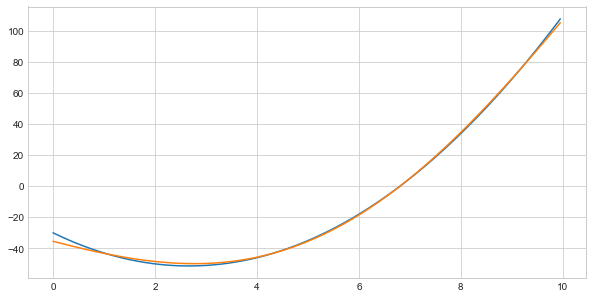

1
tensor(173.2973, device='cuda:0', dtype=torch.float64)
999 epoch MSE Loss: 0.5226439665967746
1999 epoch MSE Loss: 0.12362246568141917
2999 epoch MSE Loss: 0.0401350053834079
3999 epoch MSE Loss: 0.017778713863640477
4999 epoch MSE Loss: 0.00960968983162278
train_loss tensor(0.0096, device='cuda:0', dtype=torch.float64)
best loss :  tensor(0.0096, device='cuda:0', dtype=torch.float64)
change lr  0.001
----------------------------------------------
change round number 6
----------------------------------------------


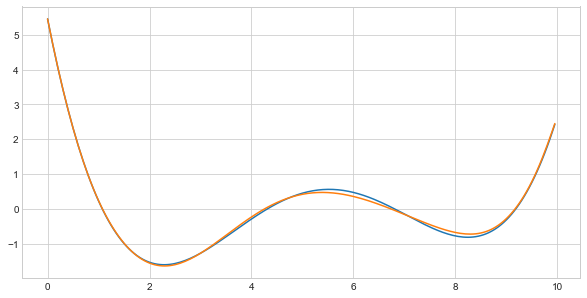

24.90575 sec


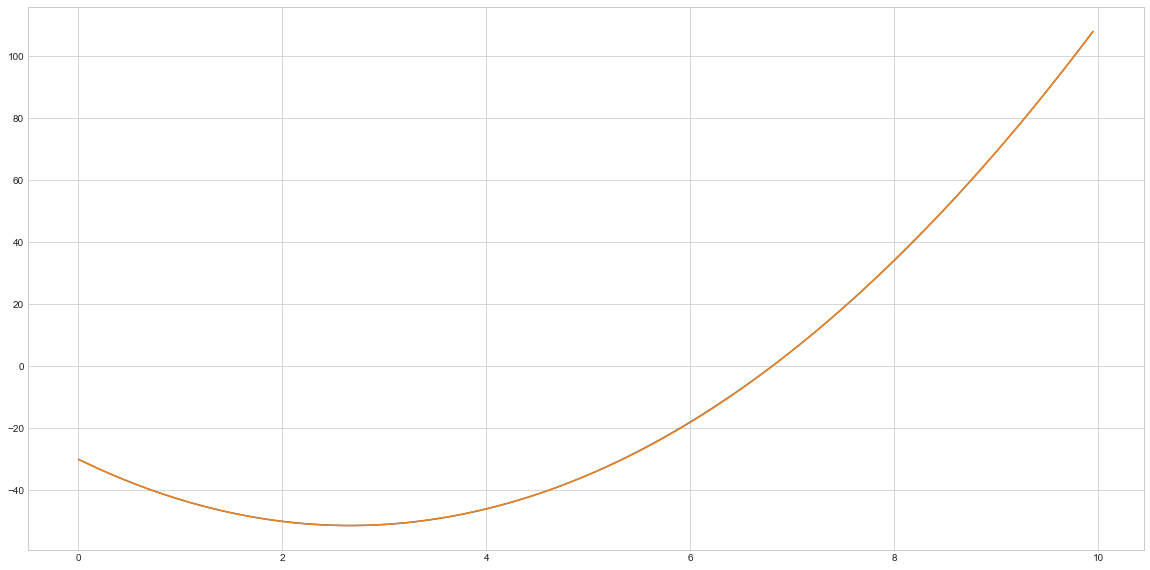

In [4]:
start = time.time()
model4 = RBF_Add(30, device)
model4.train(input_, target2, 5000, 1e-05, 0.01, 10)
end = time.time()
print(f"{end - start:.5f} sec")

plt.figure(figsize=(20,10))
plt.plot(input_.cpu().detach().numpy(), target2[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model4.pred(input_)[1][0].cpu().detach().numpy())
#rbf_grad2 = rbf_gradient(input_2, model4.done_radial_layer_centers, model4.done_radial_sigma, model4.done_linear_layer_weights)